# Recommendation Systems

In this Notebook, we implement and evaluate different techniques to estimate user ratings to movies based on past predictions on similar movies and other users predictions. <br>
We use a dataset that contains a list of movies with corresponding ratings for each user and a list of movies with corresponding genres.

In [1]:
from utils import create_train_test_masks, Jaccard_matrix, knn_estimation, train_latent_model, build_latent_nn, test_model, optimal_knn_model
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import solve
import matplotlib.pyplot as plt

## Data Exploration

In [2]:
movie_genres = pd.read_csv('movie_reviews/movie_genres.csv')
user_reviews = pd.read_csv('movie_reviews/user_reviews.csv')

In [3]:
print(f'Dimensions: {movie_genres.shape}')
movie_genres.head()

Dimensions: (2000, 27)


,Unnamed: 0,movie_title,genre_action,genre_adventure,genre_animation,genre_biography,genre_comedy,genre_crime,genre_documentary,genre_drama,...,genre_mystery,genre_news,genre_reality-tv,genre_romance,genre_sci-fi,genre_short,genre_sport,genre_thriller,genre_war,genre_western
0,0,The Net,1,0,0,0,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
1,1,Happily N'Ever After,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,Tomorrowland,1,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,3,American Hero,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,4,Das Boot,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0


As we can see, the movie_genres dataset contains 2000 movies, and each of them has 25 possible genres.

In [4]:
print(f'Dimensions: {user_reviews.shape}')
user_reviews.head()

Dimensions: (600, 2002)


,Unnamed: 0,User,The Net,Happily N'Ever After,Tomorrowland,American Hero,Das Boot,Final Destination 3,Licence to Kill,The Hundred-Foot Journey,...,The Martian,Micmacs,Solomon and Sheba,In the Company of Men,Silent House,Big Fish,Get Real,Trading Places,DOA: Dead or Alive,Hey Arnold! The Movie
0,0,Vincent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Edgar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Addilyn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Marlee,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Javier,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In this case, the user_reviews dataframe contains 600 rows corresponding to users and 2000 rows corresponding to movies. The movies match the ones seen in the movie_genres dataframe.

In [5]:
# We define the matrix of Ratings and the matrix of Genres
R = user_reviews.iloc[:, 2:].copy().to_numpy()  
G = movie_genres.iloc[:, 2:].copy()
n_users, n_movies = R.shape

In [6]:
R_rest, R_test = create_train_test_masks(R, 0.9)

assert R_rest[R_rest != 0].shape[0] + R_test[R_test != 0].shape[0] == R[R != 0].shape[0]

R_train, R_val = create_train_test_masks(R_rest, 0.8)

assert R_train[R_train != 0].shape[0] + R_val[R_val != 0].shape[0] == R_rest[R_rest != 0].shape[0]
assert R_train[R_train != 0].shape[0] + R_val[R_val != 0].shape[0] + R_test[R_test != 0].shape[0] == R[R != 0].shape[0]

print(f"Ratings in R:\t\t {np.sum(R > 0)}")
print(f"Ratings in R_train:\t {np.sum(R_train > 0)}")
print(f"Ratings in R_val:\t {np.sum(R_val > 0)}")
print(f"Ratings in R_test:\t {np.sum(R_test > 0)}")

Ratings in R:		 16525
Ratings in R_train:	 11897
Ratings in R_val:	 2975
Ratings in R_test:	 1653


## K-NN Approach

In this section, we implement a classical method for predicting movie ratings based on the K-NN method. Here we exploit the local relationships between movies that are close (according to some meaninful metric) to output a good prediction. <br>
The method is good at learning local structures, but lacks the capabilities to learn weak signals between datapoints that are far. Nonetheless, it can still output good predictions.

### Neighborhood Parameter Finetuning

The KNN method is based on selecting a neighborhood around each datapoint, and then using the local information to make a prediction about it. It is therefore crucial to select a distance parameter as threshold to select which elements are in the neighborhood and which are not. In this section we first optimize over that parameter, and then we run the KNN prediction and see the results.

In [7]:
# finetuning of the hyperparameter and get the best model

interval = np.linspace(0.1, 0.6, 7)
best_threshold, best_error, best_predictions = optimal_knn_model(interval, R_rest, R_train, R_val, G)

print(f"Best threshold: {best_threshold}, Best error: {best_error}")

Testing threshold: 0.1


Users Processed::   0%|          | 0/600 [00:00<?, ?it/s]/Users/alessandroardenghi/AILAB/Recommendation_System/utils.py:89: RuntimeWarning: Mean of empty slice
  b_u = np.nanmean(user_reviews.replace(0, np.nan), axis=0)
Users Processed:: 100%|██████████| 600/600 [02:04<00:00,  4.82it/s]


RMSE: 1.1509816259787964
Testing threshold: 0.18333333333333335


Users Processed:: 100%|██████████| 600/600 [01:39<00:00,  6.05it/s]


RMSE: 1.149349441689475
Testing threshold: 0.26666666666666666


Users Processed:: 100%|██████████| 600/600 [01:01<00:00,  9.80it/s]


RMSE: 1.1758152154778045
Testing threshold: 0.35


Users Processed:: 100%|██████████| 600/600 [00:42<00:00, 14.27it/s]


RMSE: 1.203819476448113
Testing threshold: 0.43333333333333335


Users Processed:: 100%|██████████| 600/600 [00:34<00:00, 17.20it/s]


RMSE: 1.2163234104071214
Testing threshold: 0.5166666666666666


Users Processed:: 100%|██████████| 600/600 [00:21<00:00, 28.18it/s]


RMSE: 1.2539032777936319
Testing threshold: 0.6


Users Processed:: 100%|██████████| 600/600 [00:21<00:00, 28.28it/s]

RMSE: 1.250750180558447

Best threshold: 0.18333333333333335 with RMSE: 1.149349441689475
Best threshold: 0.18333333333333335, Best error: 1.149349441689475


We can see the ratings predicted for the first 5 users:

In [8]:
best_predictions.head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,4.588884,3.012325,3.914141,4.057475,4.936591,4.738095,3.568338,4.007378,3.156014,4.332298,...,4.157913,3.669157,3.814479,3.793093,4.963191,3.766305,4.340441,2.970434,2.826681,3.874092
1,4.198374,4.800000,4.074849,4.008646,5.171600,2.433333,3.492457,4.049064,2.999289,3.096997,...,4.158986,3.262096,4.872572,3.834778,4.408088,4.060333,4.846321,2.465816,3.017146,4.285714
2,3.447722,4.386459,3.732973,3.811267,4.147644,3.334145,3.160659,3.996604,2.442644,2.915192,...,3.535181,4.066504,3.685446,3.782318,3.777079,3.503739,4.552764,3.836979,2.614969,4.795469
3,4.983321,3.663954,4.595273,3.478105,5.208181,2.927536,3.837135,3.395926,3.032143,3.596820,...,3.760215,3.606819,3.698280,3.181640,4.593239,3.475926,3.875444,2.527944,2.772565,3.834893
4,2.861898,4.327844,4.472222,3.296695,3.737256,2.619048,3.386905,3.391801,3.169643,2.442857,...,3.090183,3.358899,3.386805,3.177516,3.256136,2.812300,4.053542,3.041209,2.929487,5.006389


## Latent Factor Model

The second approach we take is to use a latent factor model to predict the ratings on movies unseen by the users. <br>
These models build a latent representation of movies and users, retaining the n most important features for the final prediction (where n is a value set before the learning phase and the features are latent). These models are great at capturing overall relations between datapoints, but have no concept of locality.

In [9]:
n_factors = 50              # We want latent vectors to have 50 features
U = np.random.rand(n_users, n_factors)      # We initialize U randomly
M = np.random.rand(n_movies, n_factors)     # We initialize M randomly
G = movie_genres.iloc[:, 2:].copy().to_numpy()

U, M = train_latent_model(n_factors, 0.1, 500, R_train, R_val)


Iteration 0, Train RMSE: 0.0323, Val RMSE: 2.5327
Iteration 50, Train RMSE: 0.0209, Val RMSE: 1.5305
Iteration 100, Train RMSE: 0.0194, Val RMSE: 1.4487
Iteration 150, Train RMSE: 0.0188, Val RMSE: 1.4180
Iteration 200, Train RMSE: 0.0184, Val RMSE: 1.4045
Iteration 250, Train RMSE: 0.0183, Val RMSE: 1.3979
Iteration 300, Train RMSE: 0.0182, Val RMSE: 1.3945
Iteration 350, Train RMSE: 0.0181, Val RMSE: 1.3927
Iteration 400, Train RMSE: 0.0181, Val RMSE: 1.3917
Iteration 450, Train RMSE: 0.0180, Val RMSE: 1.3911
Training Finished


In [14]:
filled_ratings = U @ M.T
test_RMSE = test_model(filled_ratings, R, R_test)   # Computing RMSE of the trained model on unseen data
print(f'TEST RMSE: {test_RMSE:.4f}')

TEST RMSE: 1.3703


## Neural Network based Latent Representations

In the previous section, we minimized the regularized L2 norm to obtain good values of U and M. This approach was limited and computationally intensive, and likely could not capture all the important relations between datapoints. <br>
In this section we propose the use of a Neural Network to learn the best possible embeddings for each user and for each movie.

In [15]:
n_users, n_movies = R.shape
latent_dim = 1000  

nn_model = build_latent_nn(n_users, n_movies, latent_dim)
nn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 1000)              600000    ['user_input[0][0]']          
                                                                                                  
 movie_embedding (Embedding  (None, 1, 1000)              2000000   ['movie_input[0][0]']         
 )                                                                                            

As we can see, most of the parameters are in the two embedding layers. <br>
The user embedding layers has n_users x 50 trainable parameters, so the model will learn the best 50-dimensional latent representation for each user. <br>
The movie embedding layers has n_movie x 50 trainable parameters, and it will do the same as the user embedding layer. <br>
Then there are 3 dense layers that take as input the concatenation of the user and movie embedding. <br>
The final dense layer, which contains a sigmoid function to normalize the output between zero and one, runs on the concatenation of the output of the dense layers and the original embeddings. <br>


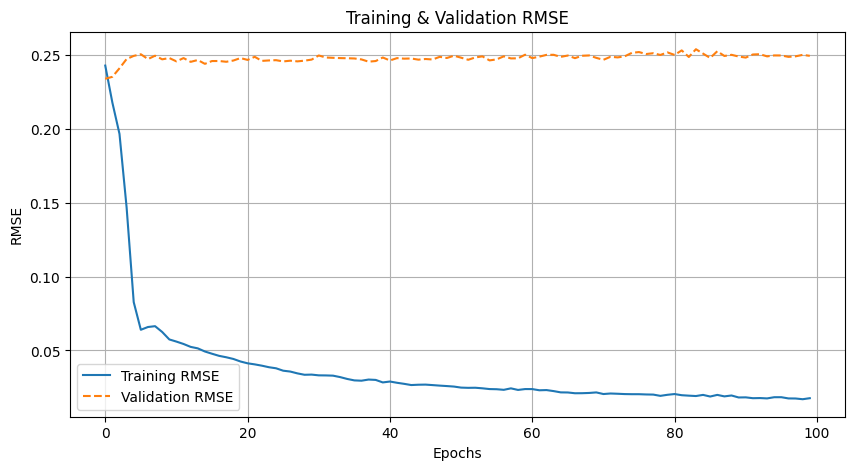

In [ ]:
train_users, train_movies = np.where(R_train > 0)       # Array of tuples of indices of (user, movie) that are nonzero
val_users, val_movies = np.where(R_val > 0)  
train_ratings = R[train_users, train_movies]/5          # We normalize ratings in [0,1]
val_ratings = R[val_users, val_movies]/5

history = nn_model.fit(
    [train_users, train_movies], train_ratings,
    validation_data=([val_users, val_movies], val_ratings),
    epochs=20, batch_size=16,
    verbose=0
)

train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training & Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
m, n = R.shape
indices = np.array(list(np.ndindex(m, n)))

users = indices[:, 0]  
movies = indices[:, 1] 

predictions = nn_model.predict([users, movies])

37500/37500 [==============================] - 21s 548us/step


In [18]:
filled_ratings = predictions.reshape(m, n)
rescaled_ratings = filled_ratings*5

In [19]:
test_RMSE = test_model(rescaled_ratings, R, R_test)   # Computing RMSE of the trained model on unseen data
print(f'TEST RMSE: {test_RMSE:.4f}')

TEST RMSE: 1.2160


## Ensemble Methods

As highlighted in the paper 'Lessons from the Netflix Prize Challenge', neither the KNN nor the latent factor models are able to fully capture the relations between points. Methods based on neighborhoods are good at understanding local relationships, but fail with weak signals from datapoints that are far. Latent factor models are good at modelling overall relations but do not capture local information well. <br>
In this section, we try to mix the results obtained by the two methods to obtain our final predictions.

In [27]:
neigh_distance = best_threshold ## use the optimal threshold that was found in the section above 
G = movie_genres.iloc[:, 2:].copy()
distance_matrix = Jaccard_matrix(G) 
n_users, n_movies = R.shape
latent_dim = 1000  

m, n = R.shape
indices = np.array(list(np.ndindex(m, n)))

users = indices[:, 0]  
movies = indices[:, 1] 

### Linear Combination of the Predictions. Finetuning for optimal $\alpha$

In [28]:
val_knn_ratings = knn_estimation(R_train, distance_matrix, neigh_distance)    

val_nn_model = build_latent_nn(n_users, n_movies, latent_dim)
train_users, train_movies = np.where(R_train > 0)       
train_ratings = R[train_users, train_movies]/5
history = val_nn_model.fit(
    [train_users, train_movies], train_ratings,
    epochs=20, batch_size=16,
    verbose=0
)


Users Processed:: 100%|██████████| 600/600 [01:38<00:00,  6.08it/s]


In [29]:
knn_val_RMSE = test_model(val_knn_ratings, R, R_val)   # Computing RMSE of the trained model on unseen data
print(f'KNN VAL RMSE: {knn_val_RMSE:.4f}')


val_predictions = val_nn_model.predict([users, movies])
val_filled_ratings = val_predictions.reshape(m, n)
val_nn_ratings = val_filled_ratings*5

nn_val_RMSE = test_model(val_nn_ratings, R, R_val)   # Computing RMSE of the trained model on unseen data
print(f'NN VAL RMSE: {nn_val_RMSE:.4f}')

KNN VAL RMSE: 1.1493
37500/37500 [==============================] - 17s 438us/step
NN VAL RMSE: 1.2331


In [34]:
alpha_values = np.linspace(0, 1, 21)
val_scores = []
for alpha in alpha_values:
    mixed_scores = alpha * val_knn_ratings + (1-alpha) * val_nn_ratings
    val_RMSE = test_model(mixed_scores, R, R_val)
    val_scores.append(val_RMSE)
best_alpha = alpha_values[np.argmin(val_scores)]
print(f'BEST ALPHA: {best_alpha:.2f}')

BEST ALPHA: 0.70


## Final Training on both training and validation sets

In [35]:
test_knn_ratings = knn_estimation(R_rest, distance_matrix, neigh_distance)    

test_nn_model = build_latent_nn(n_users, n_movies, latent_dim)
train_users, train_movies = np.where(R_rest > 0)       
train_ratings = R[train_users, train_movies]/5
history = test_nn_model.fit(
    [train_users, train_movies], train_ratings,
    epochs=20, batch_size=16,
    verbose=0
)

/Users/alessandroardenghi/AILAB/Recommendation_System/utils.py:89: RuntimeWarning: Mean of empty slice
  b_u = np.nanmean(user_reviews.replace(0, np.nan), axis=0)
Users Processed:: 100%|██████████| 600/600 [01:38<00:00,  6.07it/s]


In [54]:
knn_test_RMSE = test_model(test_knn_ratings.clip(upper=5.0, lower=0.0), R, R_test)   # Computing RMSE of the trained model on unseen data
print(f'KNN TEST RMSE: {knn_test_RMSE:.4f}')


test_predictions = test_nn_model.predict([users, movies])
test_filled_ratings = test_predictions.reshape(m, n)
test_nn_ratings = test_filled_ratings*5

nn_test_RMSE = test_model(test_nn_ratings, R, R_test)   # Computing RMSE of the trained model on unseen data
print(f'NN TEST RMSE: {nn_test_RMSE:.4f}')

mixed_scores = best_alpha * test_knn_ratings.clip(upper=5.0, lower=0.0) + (1-best_alpha) * test_nn_ratings
test_mixed_RMSE = test_model(mixed_scores, R, R_test)

print(f'ENSEMBLE TEST RMSE: {test_mixed_RMSE:.4f}')

KNN TEST RMSE: 1.0659
37500/37500 [==============================] - 16s 437us/step
NN TEST RMSE: 1.1738
ENSEMBLE TEST RMSE: 1.0517


## Extract the top 5 movies for the first 5 users

In this section, we recommend 5 unseen movies to each of the first 5 users in our list.

In [165]:
modified_mixed_scores = mixed_scores.to_numpy().copy()
modified_mixed_scores[R != 0] = -100                                        # Making sure movies alrady rated do not end up in the top 5

first_five_rows = modified_mixed_scores[:5]                                 # Selecting first 5 users
sorted_indices_desc = np.argsort(-first_five_rows, axis=1)[:, :5]           # Sorting in descending order
column_names = user_reviews.columns.to_numpy()[2:]                          # Array with movie names
movie_matrix = column_names[sorted_indices_desc]                            # Array with best 5 movies for the first 5 users

row_indices = np.arange(sorted_indices_desc.shape[0]).reshape(-1, 1)
scores_given_by_users = R[row_indices, sorted_indices_desc]                 # Array with ratings of best 5 movies for first 5 users (all 0)
best_scores = modified_mixed_scores[row_indices, sorted_indices_desc]       # Array with predicted ratings of 5 best movies

In [186]:
for i in range(sorted_indices_desc.shape[0]):
    print(f'Recommended Movies for User {i}:')
    for j in range(sorted_indices_desc.shape[1]):
        print(f'\t\tTitle: {movie_matrix[i][j]:<40} Predicted Rating: {best_scores[i, j]:<20.2f} Movie Index = {sorted_indices_desc[i, j]}')

Recommended Movies for User 0:
		Title: The Hunting Party                        Predicted Rating: 4.92                 Movie Index = 1388
		Title: Chill Factor                             Predicted Rating: 4.91                 Movie Index = 630
		Title: The Tempest                              Predicted Rating: 4.89                 Movie Index = 1346
		Title: Blue Like Jazz                           Predicted Rating: 4.89                 Movie Index = 1932
		Title: The Bodyguard                            Predicted Rating: 4.88                 Movie Index = 907
Recommended Movies for User 1:
		Title: The Bodyguard                            Predicted Rating: 4.98                 Movie Index = 907
		Title: Collateral                               Predicted Rating: 4.97                 Movie Index = 1491
		Title: Elizabethtown                            Predicted Rating: 4.97                 Movie Index = 666
		Title: Ip Man 3                                 Predicted Rating: 4.97      